In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

class Tetris:
    def __init__(self, H=8, W=6, gravity_speed=0.1):
        self.H = H
        self.W = W
        self.gravity_speed = gravity_speed

        self.COLORS = {
            0: (0,0,0),
            1: (0,1,1),
            2: (1,1,0),
            3: (0.6,0,0.8),
            4: (1,0.5,0),
            5: (0,0,1),
            6: (0,1,0),
            7: (1,0,0),
        }

        self.reset()

    #Tetromino
    def get_tetrominoes(self):
        return {
            1: [np.array([[1,1,1,1]]),
                np.array([[1],[1],[1],[1]]),
                np.array([[1,1,1,1]]),
                np.array([[1],[1],[1],[1]])],
            2: [np.array([[2,2],
                          [2,2]])] * 4,
            3: [np.array([[0,3,0],[3,3,3]]),
                np.array([[3,0],[3,3],[3,0]]),
                np.array([[3,3,3],[0,3,0]]),
                np.array([[0,3],[3,3],[0,3]])],}

    #RESET
    def reset(self):
        self.board = np.zeros((self.H, self.W), dtype=int)
        self.tetrominoes = self.get_tetrominoes()

        allowed_ids = [1, 2, 3]
        self.current_id = random.choice(allowed_ids)
        self.next_id = random.choice(allowed_ids)

        self.rotation = 0
        self.piece = self.tetrominoes[self.current_id][self.rotation]
        piece_w = self.piece.shape[1]

        self.px = random.randint(0, self.W - piece_w)
        self.py = 0
        self.score = 0
        self.done = False
        self._line_reward = 0
        return self.get_state()

    #Collision
    def collision(self, px, py, piece):
        for r in range(len(piece)):
            for c in range(len(piece[0])):
                if piece[r][c] != 0:
                    br = py + r
                    bc = px + c
                    if br < 0 or br >= self.H or bc < 0 or bc >= self.W:
                        return True
                    if self.board[br][bc] != 0:
                        return True
        return False

    #Lock + Clear + Spawn
    def lock_piece(self):
        p = self.piece
        for r in range(len(p)):
            for c in range(len(p[0])):
                if p[r][c] != 0:
                    self.board[self.py + r][self.px + c] = p[r][c]

        self.clear_lines()
        self.spawn_new_piece()

    def spawn_new_piece(self):
        allowed_ids = [1, 2, 3]
        self.current_id = self.next_id
        self.next_id = random.choice(allowed_ids)

        self.rotation = 0
        self.piece = self.tetrominoes[self.current_id][self.rotation]
        piece_w = self.piece.shape[1]
        self.px = random.randint(0, self.W - piece_w)
        self.py = 0

        if self.collision(self.px, self.py, self.piece):
            self.done = True

    def clear_lines(self):
        full = [i for i in range(self.H) if np.all(self.board[i] != 0)]

        if len(full) > 0:
            self.board = np.delete(self.board, full, axis=0)
            self.board = np.vstack((np.zeros((len(full), self.W), int), self.board))

            self.score += len(full)
            self._line_reward = len(full)
        else:
            self._line_reward = 0

    #Rotate
    def rotate_piece(self):
        new_rot = (self.rotation + 1) % 4
        new_piece = self.tetrominoes[self.current_id][new_rot]

        if not self.collision(self.px, self.py, new_piece):
            self.rotation = new_rot
            self.piece = new_piece

    #STEP
    # 0 no-op, 1 left, 2 right, 3 rotate, 4 soft drop
    def step(self, action):
        if self.done:
            return self.get_state(), 0, True
        # LEFT
        if action == 1 and not self.collision(self.px - 1, self.py, self.piece):
            self.px -= 1
        # RIGHT
        if action == 2 and not self.collision(self.px + 1, self.py, self.piece):
            self.px += 1
        # ROTATE
        if action == 3:
            self.rotate_piece()
        # SOFT DROP
        if action == 4 and not self.collision(self.px, self.py + 1, self.piece):
            self.py += 1
        # GRAVITY
        if self.collision(self.px, self.py + 1, self.piece):
            self.lock_piece()
        else:
            self.py += 1

        # REWARD
        rw = -0.01 + self._line_reward
        return self.get_state(), rw, self.done

    #STATE
    def get_state(self):
        temp = self.board.copy()

        if self.done:
            return temp

        p = self.piece
        for r in range(len(p)):
            for c in range(len(p[0])):
                if p[r][c] != 0:
                    br = self.py + r
                    bc = self.px + c
                    if 0 <= br < self.H and 0 <= bc < self.W:
                        temp[br][bc] = p[r][c]
        return temp
    def get_next_piece_matrix(self):
        return self.tetrominoes[self.next_id][0]

    #RENDER
    def render(self, pause=0.1, info_text = None):
        clear_output(wait=True)

        state = self.get_state()
        rgb = np.zeros((self.H, self.W, 3))

        for r in range(self.H):
            for c in range(self.W):
                rgb[r,c] = self.COLORS[state[r,c]]
        ghost_y = None
        if not self.done:
            gy=self.py
            while not self.collision(self.px, gy+1, self.piece):
                gy += 1
            ghost_y = gy
        fig, (ax_board, ax_next) = plt.subplots(
            1, 2, figsize=(5,6),
            gridspec_kw={'width_ratios': [3,1]}
        )
        #Board
        ax_board.imshow(rgb)
        ax_board.set_title(f"Mini Tetris | Score: {self.score}")
        ax_board.set_xticks([]); ax_board.set_yticks([])
        for y in range(self.H):
            for x in range(self.W):
                ax_board.add_patch(
                    plt.Rectangle((x-0.5, y-0.5), 1, 1,
                                  fill=False, edgecolor='0.3', linewidth=0.5))
        for y in range(self.H):
            for x in range(self.W):
                if state[y,x] != 0:
                    ax_board.add_patch(
                        plt.Rectangle((x-0.5, y-0.5),1,1,
                                      fill=False,edgecolor='white',linewidth=1.5))

        if (ghost_y is not None) and (ghost_y != self.py):
            p = self.piece
            for r in range(len(p)):
                for c in range(len(p[0])):
                    if p[r,c] != 0:
                        gy= ghost_y + r
                        gx = self.px + c
                        if 0 <= gy < self.H and 0 <= gx < self.W:
                            ax_board.add_patch(
                                plt.Rectangle((gx-0.5, gy-0.5),1,1,
                                              fill=True,facecolor='white',
                                              alpha=0.18, edgecolor='white',
                                              linewidth=0.7,linestyle='dashed'))
        if self.done:
            ax_board.text(
                self.W/2 - 0.5,
                self.H/2 - 1.0,
                "GAME OVER",
                ha='center', va='center',
                fontsize=16, fontweight='bold',
                color='red',
                bbox=dict(facecolor='white', alpha=0.85, boxstyle="round")
            )

            if info_text is not None:
                ax_board.text(
                    self.W/2 - 0.5,
                    self.H/2 + 1.0,
                    info_text,
                    ha='center', va='center',
                    fontsize=10,
                    color='white',
                    bbox=dict(facecolor='black', alpha=0.5, boxstyle="round")
                )

        next_p = self.get_next_piece_matrix()
        h, w = next_p.shape
        size = 4
        preview = np.zeros((size, size, 3))
        offset_r = (size - h) // 2
        offset_c = (size - w) // 2

        for r in range(h):
            for c in range(w):
                val = next_p[r, c]
                if val != 0:
                    preview[offset_r + r, offset_c + c] = self.COLORS[val]

        ax_next.imshow(preview)
        ax_next.set_title("Next")
        ax_next.set_xticks([]); ax_next.set_yticks([])

        for y in range(size):
            for x in range(size):
                ax_next.add_patch(
                    plt.Rectangle((x-0.5, y-0.5), 1, 1,
                                  fill=False,edgecolor='white',linewidth=0.8))

        plt.tight_layout()
        plt.show()
        plt.pause(pause)


**MONTE CARLO**

In [ ]:

from collections import defaultdict

ACTIONS = [0, 1, 2, 3, 4]   # 0: no-op, 1:left, 2:right, 3:rotate, 4:soft drop
Q = defaultdict(lambda: 0.0)
Returns = defaultdict(list)

LINE_REWARD   = 5.0    # thưởng mỗi line clear
HOLE_PENALTY  = 0.01   # phạt nếu tạo thêm hole
STEP_PENALTY  = 0.005   # phạt theo step

def count_holes_from_board(board):
    H, W = board.shape
    holes = 0
    for c in range(W):
        col = board[:, c]
        filled = np.where(col != 0)[0]
        if len(filled) == 0:
            continue
        holes += np.sum(col[filled[0]:] == 0)
    return holes

def encode_state(env):
    board = env.board
    H, W = board.shape

    heights = []
    for c in range(W):
        col = board[:, c]
        filled = np.where(col != 0)[0]
        if len(filled) == 0:
            heights.append(0)
        else:
            h = H - filled[0]
            heights.append(h)

    holes = count_holes_from_board(board)
    return tuple(heights) + (holes, env.current_id, env.px, env.rotation)


def epsilon_greedy(state, epsilon=0.2):
    if np.random.rand() < epsilon:
        return random.choice(ACTIONS)

    qs = [Q[(state, a)] for a in ACTIONS]
    max_q = max(qs)
    best_actions = [a for a, q in zip(ACTIONS, qs) if abs(q - max_q) < 1e-8]
    return random.choice(best_actions)


def generate_episode(env, epsilon=0.2, max_steps=1000):
    states, actions, rewards = [], [], []

    env.reset()
    state = encode_state(env)

    for _ in range(max_steps):
        action = epsilon_greedy(state, epsilon)

        holes_before = count_holes_from_board(env.board)
        score_before = env.score

        _, _, done = env.step(action)

        holes_after = count_holes_from_board(env.board)
        score_after = env.score

        lines_cleared = score_after - score_before
        extra_holes = max(holes_after - holes_before, 0)

        reward = -STEP_PENALTY \
                 + LINE_REWARD * lines_cleared \
                 - HOLE_PENALTY * extra_holes

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        if done:
            break

        state = encode_state(env)

    return states, actions, rewards


def compute_returns(rewards, gamma=0.99):
    G = 0.0
    out = []
    for r in reversed(rewards):
        G = r + gamma * G
        out.append(G)
    return list(reversed(out))


def mc_control(env, episodes=3000, gamma=0.99, epsilon=0.1):
    for ep in range(1, episodes + 1):
        states, actions, rewards = generate_episode(env, epsilon)
        G = compute_returns(rewards, gamma)

        for t in range(len(states)):
            sa = (states[t], actions[t])
            Returns[sa].append(G[t])
            Q[sa] = np.mean(Returns[sa])

        if ep % 200 == 0:
            print(f"[MC] Episode {ep}/{episodes} | Lines = {env.score} | TotalR = {sum(rewards):.2f}")

    print("MC Control training")
    return Q


def test_one_game_mc(env, Q, max_steps=500, pause=0.15):
    env.reset()
    state = encode_state(env)
    total_reward = 0.0
    steps = 0

    while steps < max_steps:
        q_vals = [Q[(state, a)] for a in ACTIONS]
        max_q = max(q_vals)
        best_actions = [a for a, q in zip(ACTIONS, q_vals) if abs(q - max_q) < 1e-8]
        action = random.choice(best_actions)

        _, rw, done = env.step(action)
        total_reward += rw
        steps += 1

        env.render(
            pause=pause,
            info_text=f"Step: {steps}\nLines: {env.score}\nTotal R: {total_reward:.2f}"
        )

        if done:
            break

        state = encode_state(env)

    print("GAME OVER!")
    print(f"Total Reward (env): {total_reward:.2f}")
    print(f"Lines cleared: {env.score}")

def evaluate_mc_agent(env, Q, n_games=10, max_steps=500):
    all_rewards = []
    all_lines = []

    for i in range(n_games):
        env.reset()
        state = encode_state(env)
        total_reward = 0.0
        steps = 0

        while steps < max_steps:
            q_vals = [Q[(state, a)] for a in ACTIONS]
            action = ACTIONS[int(np.argmax(q_vals))]

            _, rw, done = env.step(action)
            total_reward += rw
            steps += 1

            if done:
                break

            state = encode_state(env)

        all_rewards.append(total_reward)
        all_lines.append(env.score)
        print(f"Game {i+1:02d} | Lines = {env.score} | TotalR (env) = {total_reward:.2f}")

    print("\nSUMMARY")
    print(f"Avg lines  : {np.mean(all_lines):.2f}")
    print(f"Avg reward : {np.mean(all_rewards):.2f}")

    return all_rewards, all_lines

In [ ]:
env = Tetris()
Q.clear(); Returns.clear()   # reset MC bảng Q


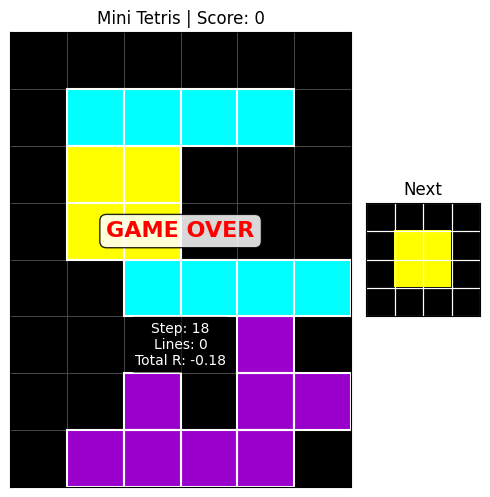

GAME OVER!
Total Reward (env): -0.18
Lines cleared: 0


In [ ]:
test_one_game_mc(env, Q, pause=0.1)

In [ ]:
def moving_average(x, window=25):
    x = np.array(x, dtype=float)
    if len(x) < window:
        return x
    kernel = np.ones(window) / window
    ma = np.convolve(x, kernel, mode='valid')
    return ma
def mc_control_with_log(env, episodes=1000, gamma=0.99, epsilon=0.2):
    global Q, Returns
    Q = defaultdict(lambda: 0.0)
    Returns = defaultdict(list)

    ep_rewards = []
    ep_lines   = []

    for ep in range(1, episodes + 1):
        states, actions, rewards = generate_episode(env, epsilon)
        G = compute_returns(rewards, gamma)

        # update every-visit
        for t in range(len(states)):
            sa = (states[t], actions[t])
            Returns[sa].append(G[t])
            Q[sa] = np.mean(Returns[sa])

        ep_rewards.append(sum(rewards))
        ep_lines.append(env.score)

        if ep % 200 == 0:
            print(f"[eps={epsilon}] Episode {ep}/{episodes} | "
                  f"Lines = {env.score} | TotalR = {sum(rewards):.2f}")

    return ep_rewards, ep_lines, Q


[eps=0.9] Episode 200/8000 | Lines = 0 | TotalR = -0.16
[eps=0.9] Episode 400/8000 | Lines = 0 | TotalR = -0.18
[eps=0.9] Episode 600/8000 | Lines = 0 | TotalR = -0.20
[eps=0.9] Episode 800/8000 | Lines = 0 | TotalR = -0.08
[eps=0.9] Episode 1000/8000 | Lines = 0 | TotalR = -0.16
[eps=0.9] Episode 1200/8000 | Lines = 0 | TotalR = -0.27
[eps=0.9] Episode 1400/8000 | Lines = 2 | TotalR = 9.79
[eps=0.9] Episode 1600/8000 | Lines = 0 | TotalR = -0.20
[eps=0.9] Episode 1800/8000 | Lines = 1 | TotalR = 4.74
[eps=0.9] Episode 2000/8000 | Lines = 0 | TotalR = -0.18
[eps=0.9] Episode 2200/8000 | Lines = 0 | TotalR = -0.25
[eps=0.9] Episode 2400/8000 | Lines = 1 | TotalR = 4.72
[eps=0.9] Episode 2600/8000 | Lines = 0 | TotalR = -0.30
[eps=0.9] Episode 2800/8000 | Lines = 0 | TotalR = -0.30
[eps=0.9] Episode 3000/8000 | Lines = 0 | TotalR = -0.19
[eps=0.9] Episode 3200/8000 | Lines = 0 | TotalR = -0.16
[eps=0.9] Episode 3400/8000 | Lines = 0 | TotalR = -0.28
[eps=0.9] Episode 3600/8000 | Lines = 

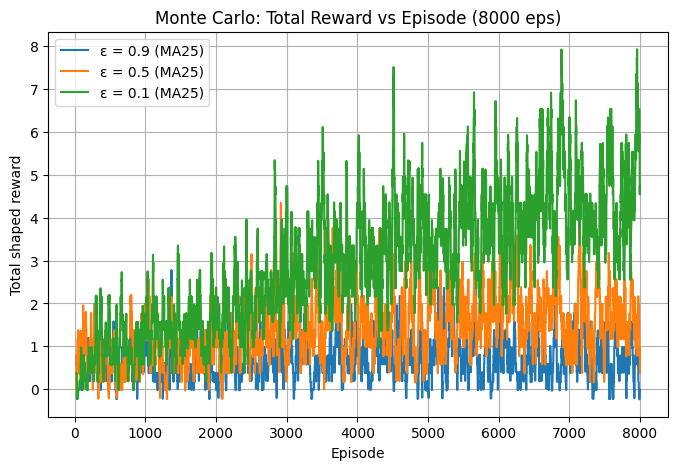

In [ ]:
import time
import pandas as pd
env = Tetris()

eps_list = [0.9, 0.5, 0.1]
episodes = 8000                # số episode cho mỗi epsilon
window_ma = 25                 # cửa sổ moving average

results_rewards = {}
results_lines   = {}
Q_dict = {}

summary_rows = []

for eps in eps_list:
    start_time = time.time()
    ep_rewards, ep_lines, Q_eps = mc_control_with_log(
        env, episodes=episodes, gamma=0.99, epsilon=eps
    )
    running_time = time.time() - start_time
    best_reward = max(ep_rewards)
    summary_rows.append({
        "epsilon": eps,
        "running_time_sec": round(running_time, 2),
        "best_reward": round(best_reward, 2)
    })

    results_rewards[eps] = ep_rewards
    results_lines[eps]   = ep_lines
    Q_dict[eps] = Q_eps

df_summary = pd.DataFrame(summary_rows)
best_row = df_summary.loc[df_summary["best_reward"].idxmax()]
best_eps = best_row["epsilon"]
print("Best epsilon:", best_eps)
print(best_row)
print(df_summary)
#Total shaped reward vs episode
plt.figure(figsize=(8,5))
all_ma_rewards = []
for eps in eps_list:
    rewards = results_rewards[eps]
    ma = moving_average(rewards, window=window_ma)
    x = np.arange(len(ma)) + (window_ma - 1)
    all_ma_rewards.extend(ma)
    plt.plot(x, ma, label=f"ε = {eps} (MA{window_ma})")
if len(all_ma_rewards) > 0:
    ymin = min(all_ma_rewards)
    ymax = max(all_ma_rewards)
    pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
    plt.ylim(ymin - pad, ymax + pad)

plt.xlabel("Episode")
plt.ylabel("Total shaped reward")
plt.title(f"Monte Carlo: Total Reward vs Episode ({episodes} eps)")
plt.legend()
plt.grid(True)
plt.show()




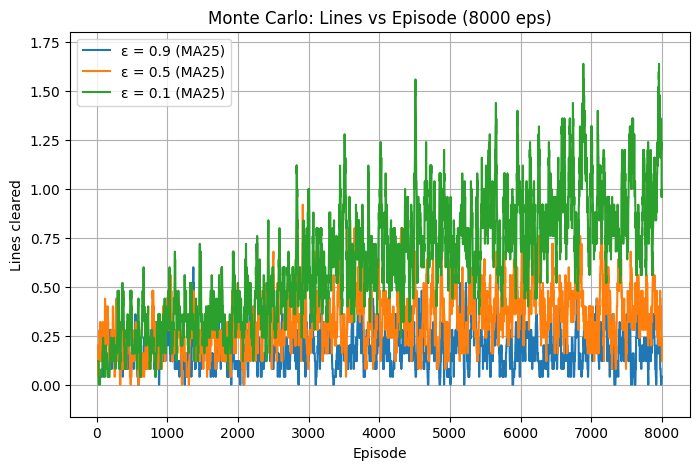

In [ ]:
plt.figure(figsize=(8,5))
all_ma_lines = []

for eps in eps_list:
    lines = results_lines[eps]
    ma = moving_average(lines, window=window_ma)
    x = np.arange(len(ma)) + (window_ma - 1)
    all_ma_lines.extend(ma)
    plt.plot(x, ma, label=f"ε = {eps} (MA{window_ma})")

if len(all_ma_lines) > 0:
    ymin = min(all_ma_lines)
    ymax = max(all_ma_lines)
    pad = 0.1 * (ymax - ymin if ymax > ymin else 1.0)
    plt.ylim(ymin - pad, ymax + pad)

plt.xlabel("Episode")
plt.ylabel("Lines cleared")
plt.title(f"Monte Carlo: Lines vs Episode ({episodes} eps)")
plt.legend()
plt.grid(True)
plt.show()


**SARSA**

In [ ]:

from collections import defaultdict

def epsilon_greedy_from_Q(Q, state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return random.choice(ACTIONS)
    qs = [Q[(state, a)] for a in ACTIONS]
    max_q = max(qs)
    best_actions = [a for a, q in zip(ACTIONS, qs) if abs(q-max_q) < 1e-8]
    return random.choice(best_actions)

def sarsa_control_with_log(env,
                           episodes=8000,
                           max_steps=1000,
                           gamma=0.99,
                           alpha=0.1,
                           epsilon=0.1):

    Q = defaultdict(lambda: 0.0)
    ep_rewards, ep_lines = [], []

    for ep in range(1, episodes+1):
        env.reset()
        state = encode_state(env)
        action = epsilon_greedy_from_Q(Q, state, epsilon)

        total_reward = 0.0

        for step in range(max_steps):
            holes_before = count_holes_from_board(env.board)
            score_before = env.score

            _, _, done = env.step(action)

            holes_after = count_holes_from_board(env.board)
            score_after = env.score

            lines = score_after - score_before
            extra_holes = max(holes_after - holes_before, 0)

            reward = -STEP_PENALTY \
                     + LINE_REWARD * lines \
                     - HOLE_PENALTY * extra_holes

            total_reward += reward

            next_state = encode_state(env) if not done else None

            if done:
                td_target = reward
                td_error = td_target - Q[(state, action)]
                Q[(state, action)] += alpha * td_error
                break
            else:
                next_action = epsilon_greedy_from_Q(Q, next_state, epsilon)
                td_target = reward + gamma * Q[(next_state, next_action)]
                td_error = td_target - Q[(state, action)]
                Q[(state, action)] += alpha * td_error

                state = next_state
                action = next_action

        ep_rewards.append(total_reward)
        ep_lines.append(env.score)

        if ep % 200 == 0:
            print(f"[SARSA eps={epsilon}] Ep {ep}/{episodes} | "
                  f"Lines = {env.score} | R = {total_reward:.2f}")

    print("SARSA training")
    return ep_rewards, ep_lines, Q


In [ ]:
eps_list = [0.9, 0.5, 0.1]
episodes = 8000
window_ma = 25

results_rewards_sarsa = {}
results_lines_sarsa   = {}
Q_sarsa_dict = {}
summary_rows_sarsa = []

for eps in eps_list:
    ep_rewards, ep_lines, Q_sarsa = sarsa_control_with_log(
        env, episodes=episodes, gamma=0.99,
        alpha=0.1, epsilon=eps
    )
    best_reward = max(ep_rewards)
    results_rewards_sarsa[eps] = ep_rewards
    results_lines_sarsa[eps]   = ep_lines
    Q_sarsa_dict[eps]          = Q_sarsa
    summary_rows_sarsa.append({
        "epsilon": eps,
        "best_reward": best_reward
    })
pd.DataFrame(summary_rows_sarsa)


[SARSA eps=0.9] Ep 200/8000 | Lines = 0 | R = -0.16
[SARSA eps=0.9] Ep 400/8000 | Lines = 0 | R = -0.12
[SARSA eps=0.9] Ep 600/8000 | Lines = 0 | R = -0.15
[SARSA eps=0.9] Ep 800/8000 | Lines = 0 | R = -0.09
[SARSA eps=0.9] Ep 1000/8000 | Lines = 0 | R = -0.28
[SARSA eps=0.9] Ep 1200/8000 | Lines = 0 | R = -0.30
[SARSA eps=0.9] Ep 1400/8000 | Lines = 0 | R = -0.26
[SARSA eps=0.9] Ep 1600/8000 | Lines = 0 | R = -0.14
[SARSA eps=0.9] Ep 1800/8000 | Lines = 0 | R = -0.30
[SARSA eps=0.9] Ep 2000/8000 | Lines = 0 | R = -0.21
[SARSA eps=0.9] Ep 2200/8000 | Lines = 0 | R = -0.14
[SARSA eps=0.9] Ep 2400/8000 | Lines = 0 | R = -0.21
[SARSA eps=0.9] Ep 2600/8000 | Lines = 1 | R = 4.77
[SARSA eps=0.9] Ep 2800/8000 | Lines = 0 | R = -0.21
[SARSA eps=0.9] Ep 3000/8000 | Lines = 0 | R = -0.23
[SARSA eps=0.9] Ep 3200/8000 | Lines = 0 | R = -0.22
[SARSA eps=0.9] Ep 3400/8000 | Lines = 0 | R = -0.29
[SARSA eps=0.9] Ep 3600/8000 | Lines = 0 | R = -0.18
[SARSA eps=0.9] Ep 3800/8000 | Lines = 1 | R = 4.69

,epsilon,best_reward
0,0.9,19.725
1,0.5,34.555
2,0.1,39.480


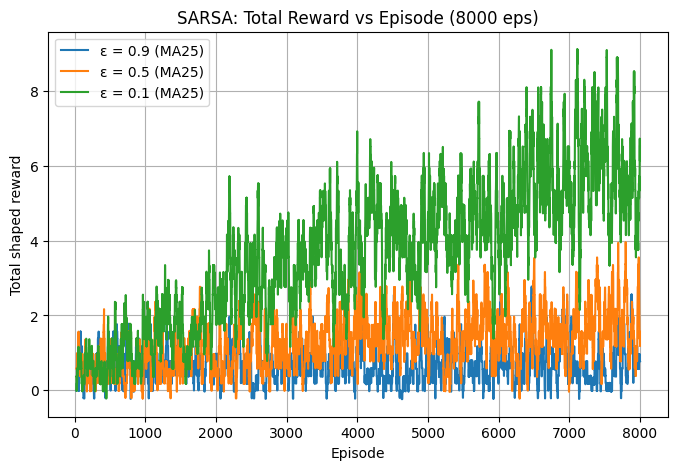

In [ ]:
plt.figure(figsize=(8,5))

eps_list  = [0.9, 0.5, 0.1]
window_ma = 25
all_ma_rewards = []

for eps in eps_list:
    rewards = results_rewards_sarsa[eps]
    ma = moving_average(rewards, window=window_ma)
    x = np.arange(len(ma)) + (window_ma - 1)

    all_ma_rewards.extend(ma)
    plt.plot(x, ma, label=f"ε = {eps} (MA{window_ma})")

if len(all_ma_rewards) > 0:
    ymin = min(all_ma_rewards)
    ymax = max(all_ma_rewards)
    pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
    plt.ylim(ymin - pad, ymax + pad)

plt.xlabel("Episode")
plt.ylabel("Total shaped reward")
plt.title(f"SARSA: Total Reward vs Episode ({len(rewards)} eps)")
plt.legend()
plt.grid(True)
plt.show()


**Q-LEARNING**

In [ ]:

from collections import defaultdict

def q_learning_control_with_log(env,
                                episodes=8000,
                                max_steps=1000,
                                gamma=0.99,
                                alpha=0.1,
                                epsilon=0.1):

    Q = defaultdict(lambda: 0.0)

    ep_rewards = []
    ep_lines   = []

    for ep in range(1, episodes + 1):
        env.reset()
        state = encode_state(env)

        total_reward = 0.0

        for step in range(max_steps):
            action = epsilon_greedy_from_Q(Q, state, epsilon)
            holes_before = count_holes_from_board(env.board)
            score_before = env.score

            _, _, done = env.step(action)

            holes_after = count_holes_from_board(env.board)
            score_after = env.score

            lines_cleared = score_after - score_before
            extra_holes   = max(holes_after - holes_before, 0)

            reward = -STEP_PENALTY \
                     + LINE_REWARD * lines_cleared \
                     - HOLE_PENALTY * extra_holes

            total_reward += reward

            next_state = encode_state(env) if not done else None

            if done:
                td_target = reward
            else:
                best_next_q = max(Q[(next_state, a)] for a in ACTIONS)
                td_target = reward + gamma * best_next_q

            td_error = td_target - Q[(state, action)]
            Q[(state, action)] += alpha * td_error

            if done:
                break

            state = next_state

        ep_rewards.append(total_reward)
        ep_lines.append(env.score)

        if ep % 200 == 0:
            print(f"[Q-learning eps={epsilon}] Ep {ep}/{episodes} | "
                  f"Lines = {env.score} | TotalR = {total_reward:.2f}")

    print(" Q-learning training!")
    return ep_rewards, ep_lines, Q


In [ ]:
env = Tetris()

eps_list   = [0.9, 0.5, 0.1]
episodes_q = 8000
window_ma  = 25

results_rewards_q = {}
results_lines_q   = {}
Q_q_dict          = {}
summary_rows_q    = []

for eps in eps_list:
    ep_rewards, ep_lines, Q_q = q_learning_control_with_log(
        env,
        episodes=episodes_q,
        max_steps=1000,
        gamma=0.99,
        alpha=0.1,
        epsilon=eps
    )
    best_reward = max(ep_rewards)

    results_rewards_q[eps] = ep_rewards
    results_lines_q[eps]   = ep_lines
    Q_q_dict[eps]          = Q_q

    summary_rows_q.append({
        "epsilon": eps,
        "best_reward": round(best_reward, 2)
    })

df_q = pd.DataFrame(summary_rows_q)
print(df_q)


[Q-learning eps=0.9] Ep 200/8000 | Lines = 0 | TotalR = -0.11
[Q-learning eps=0.9] Ep 400/8000 | Lines = 0 | TotalR = -0.26
[Q-learning eps=0.9] Ep 600/8000 | Lines = 0 | TotalR = -0.29
[Q-learning eps=0.9] Ep 800/8000 | Lines = 0 | TotalR = -0.17
[Q-learning eps=0.9] Ep 1000/8000 | Lines = 0 | TotalR = -0.19
[Q-learning eps=0.9] Ep 1200/8000 | Lines = 0 | TotalR = -0.13
[Q-learning eps=0.9] Ep 1400/8000 | Lines = 0 | TotalR = -0.25
[Q-learning eps=0.9] Ep 1600/8000 | Lines = 0 | TotalR = -0.11
[Q-learning eps=0.9] Ep 1800/8000 | Lines = 0 | TotalR = -0.20
[Q-learning eps=0.9] Ep 2000/8000 | Lines = 0 | TotalR = -0.18
[Q-learning eps=0.9] Ep 2200/8000 | Lines = 4 | TotalR = 19.57
[Q-learning eps=0.9] Ep 2400/8000 | Lines = 0 | TotalR = -0.29
[Q-learning eps=0.9] Ep 2600/8000 | Lines = 0 | TotalR = -0.25
[Q-learning eps=0.9] Ep 2800/8000 | Lines = 0 | TotalR = -0.26
[Q-learning eps=0.9] Ep 3000/8000 | Lines = 0 | TotalR = -0.17
[Q-learning eps=0.9] Ep 3200/8000 | Lines = 0 | TotalR = -0

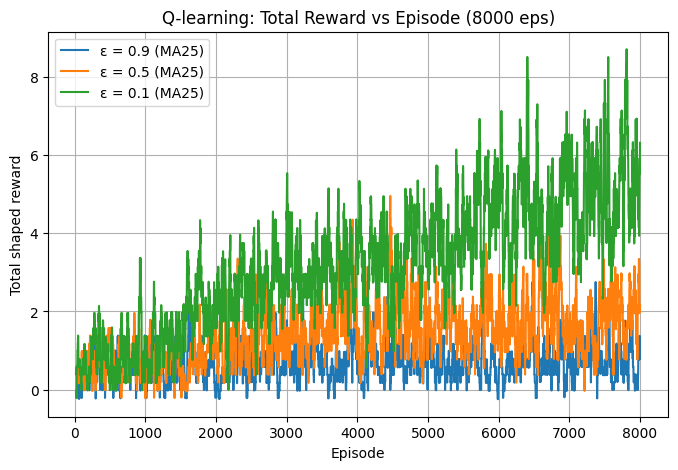

In [ ]:
plt.figure(figsize=(8,5))
all_ma_rewards = []

for eps in eps_list:
    rewards = results_rewards_q[eps]
    ma = moving_average(rewards, window=window_ma)
    x = np.arange(len(ma)) + (window_ma - 1)
    all_ma_rewards.extend(ma)
    plt.plot(x, ma, label=f"ε = {eps} (MA{window_ma})")

if len(all_ma_rewards) > 0:
    ymin = min(all_ma_rewards)
    ymax = max(all_ma_rewards)
    pad = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
    plt.ylim(ymin - pad, ymax + pad)

plt.xlabel("Episode")
plt.ylabel("Total shaped reward")
plt.title(f"Q-learning: Total Reward vs Episode ({episodes_q} eps)")
plt.legend()
plt.grid(True)
plt.show()


MC summary:
   epsilon  running_time_sec  best_reward
0      0.9             35.12        19.73
1      0.5             38.33        24.62
2      0.1             51.79        59.31 

SARSA summary:
   epsilon  best_reward
0      0.9       19.725
1      0.5       34.555
2      0.1       39.480 

Q-learning summary:
   epsilon  best_reward
0      0.9        19.69
1      0.5        29.63
2      0.1        54.25 

Best eps MC    : 0.1
Best eps SARSA : 0.1
Best eps Q     : 0.1


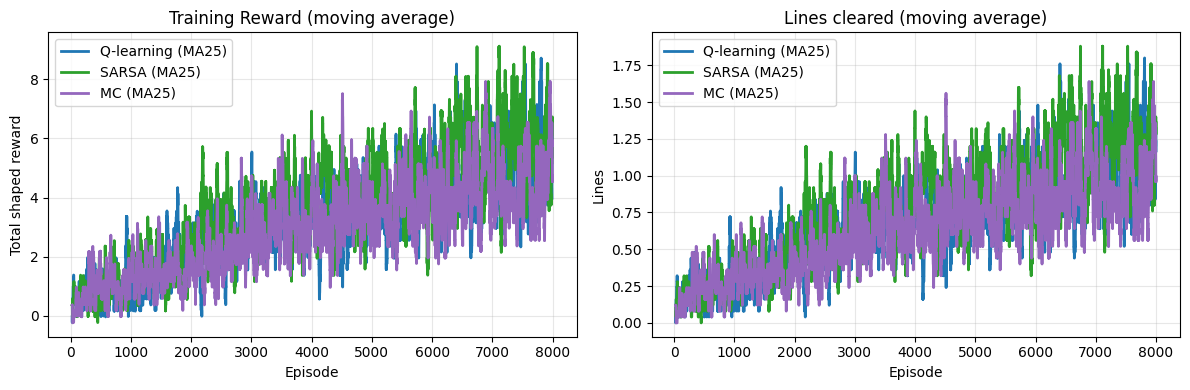

In [ ]:

df_sarsa = pd.DataFrame(summary_rows_sarsa)

print("MC summary:")
print(df_summary, "\n")
print("SARSA summary:")
print(df_sarsa, "\n")
print("Q-learning summary:")
print(df_q, "\n")

best_eps_mc    = df_summary.loc[df_summary["best_reward"].idxmax(), "epsilon"]
best_eps_sarsa = df_sarsa.loc[df_sarsa["best_reward"].idxmax(), "epsilon"]
best_eps_q     = df_q.loc[df_q["best_reward"].idxmax(), "epsilon"]

print("Best eps MC    :", best_eps_mc)
print("Best eps SARSA :", best_eps_sarsa)
print("Best eps Q     :", best_eps_q)

mc_rewards    = results_rewards[best_eps_mc]
sarsa_rewards = results_rewards_sarsa[best_eps_sarsa]
q_rewards     = results_rewards_q[best_eps_q]

mc_lines      = results_lines[best_eps_mc]
sarsa_lines   = results_lines_sarsa[best_eps_sarsa]
q_lines       = results_lines_q[best_eps_q]

window_ma = 25
fig, axes = plt.subplots(1, 2, figsize=(12,4))

colors = {
    "Q-learning": "tab:blue",
    "SARSA":      "tab:green",
    "MC":         "tab:purple"
}

ax = axes[0]

all_ma_reward_vals = []

for name, rewards, color in [
    ("Q-learning", q_rewards,     colors["Q-learning"]),
    ("SARSA",      sarsa_rewards, colors["SARSA"]),
    ("MC",         mc_rewards,    colors["MC"]),
]:
    ma = moving_average(rewards, window_ma)
    x  = np.arange(len(ma)) + (window_ma - 1)
    all_ma_reward_vals.extend(ma)
    ax.plot(x, ma, color=color, linewidth=2,
            label=f"{name} (MA{window_ma})")

if len(all_ma_reward_vals) > 0:
    ymin = min(all_ma_reward_vals)
    ymax = max(all_ma_reward_vals)
    pad  = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
    ax.set_ylim(ymin - pad, ymax + pad)

ax.set_title("Training Reward (moving average)")
ax.set_xlabel("Episode")
ax.set_ylabel("Total shaped reward")
ax.grid(True, alpha=0.3)
ax.legend()

ax2 = axes[1]

all_ma_line_vals = []

for name, lines, color in [
    ("Q-learning", q_lines,     colors["Q-learning"]),
    ("SARSA",      sarsa_lines, colors["SARSA"]),
    ("MC",         mc_lines,    colors["MC"]),
]:
    ma = moving_average(lines, window_ma)
    x  = np.arange(len(ma)) + (window_ma - 1)
    all_ma_line_vals.extend(ma)
    ax2.plot(x, ma, color=color, linewidth=2,
             label=f"{name} (MA{window_ma})")

if len(all_ma_line_vals) > 0:
    ymin = min(all_ma_line_vals)
    ymax = max(all_ma_line_vals)
    pad  = 0.05 * (ymax - ymin if ymax > ymin else 1.0)
    ax2.set_ylim(ymin - pad, ymax + pad)

ax2.set_title("Lines cleared (moving average)")
ax2.set_xlabel("Episode")
ax2.set_ylabel("Lines")
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
def evaluate_agent_greedy(env, Q, n_games=50, max_steps=1000):
    all_rewards = []
    all_lines   = []

    for g in range(n_games):
        env.reset()
        state = encode_state(env)
        total_reward = 0.0

        for step in range(max_steps):
            # greedy theo Q
            q_vals = [Q[(state, a)] for a in ACTIONS]
            best_a = ACTIONS[int(np.argmax(q_vals))]

            _, rw, done = env.step(best_a)
            total_reward += rw

            if done:
                break

            state = encode_state(env)

        all_rewards.append(total_reward)
        all_lines.append(env.score)

    return np.array(all_rewards), np.array(all_lines)
env_eval = Tetris()

Q_mc_best    = Q_dict[best_eps_mc]
Q_sarsa_best = Q_sarsa_dict[best_eps_sarsa]
Q_q_best     = Q_q_dict[best_eps_q]

rw_mc,    lines_mc    = evaluate_agent_greedy(env_eval, Q_mc_best)
rw_sarsa, lines_sarsa = evaluate_agent_greedy(env_eval, Q_sarsa_best)
rw_q,     lines_q     = evaluate_agent_greedy(env_eval, Q_q_best)

print("Eval MC    - mean lines:", lines_mc.mean(),    "| mean reward:", rw_mc.mean())
print("Eval SARSA - mean lines:", lines_sarsa.mean(), "| mean reward:", rw_sarsa.mean())
print("Eval Q     - mean lines:", lines_q.mean(),     "| mean reward:", rw_q.mean())



Eval MC    - mean lines: 1.12 | mean reward: 5.383799999999999
Eval SARSA - mean lines: 1.54 | mean reward: 7.2886000000000015
Eval Q     - mean lines: 1.5 | mean reward: 7.304200000000003


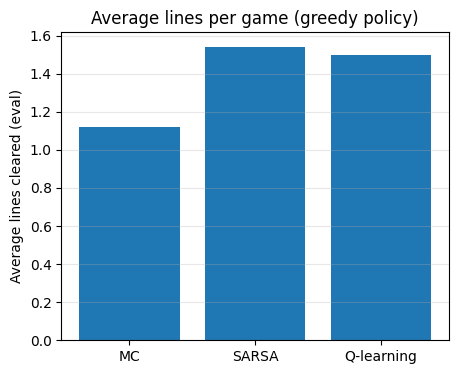

In [ ]:
labels = ["MC", "SARSA", "Q-learning"]
mean_lines = [lines_mc.mean(), lines_sarsa.mean(), lines_q.mean()]

plt.figure(figsize=(5,4))
plt.bar(labels, mean_lines)
plt.ylabel("Average lines cleared (eval)")
plt.title("Average lines per game (greedy policy)")
plt.grid(axis='y', alpha=0.3)
plt.show()


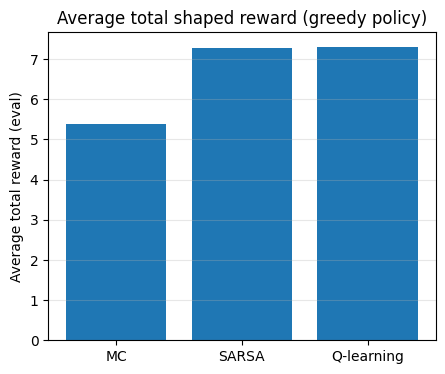

In [ ]:
mean_rewards = [rw_mc.mean(), rw_sarsa.mean(), rw_q.mean()]

plt.figure(figsize=(5,4))
plt.bar(labels, mean_rewards)
plt.ylabel("Average total reward (eval)")
plt.title("Average total shaped reward (greedy policy)")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [ ]:
# ===================== PARAMETER SWEEP FOR SARSA & Q-LEARNING =====================

def sweep_sarsa_alpha_gamma(env,
                            alpha_list=[0.05, 0.1, 0.2],
                            gamma_list=[0.95, 0.99],
                            epsilon=0.1,
                            episodes=3000,
                            max_steps=1000):
    """
    Chạy SARSA với nhiều (alpha, gamma), lưu best reward và avg lines.
    """
    rows = []

    for g in gamma_list:
        for a in alpha_list:
            print(f"\n[SARSA sweep] alpha={a}, gamma={g}")
            ep_rewards, ep_lines, Q_sarsa = sarsa_control_with_log(
                env,
                episodes=episodes,
                max_steps=max_steps,
                gamma=g,
                alpha=a,
                epsilon=epsilon
            )
            best_reward = max(ep_rewards)
            avg_lines = np.mean(ep_lines)

            rows.append({
                "algo": "SARSA",
                "alpha": a,
                "gamma": g,
                "best_reward": best_reward,
                "avg_lines": avg_lines
            })

    df = pd.DataFrame(rows)
    return df


def sweep_q_alpha_gamma(env,
                        alpha_list=[0.05, 0.1, 0.2],
                        gamma_list=[0.95, 0.99],
                        epsilon=0.1,
                        episodes=3000,
                        max_steps=1000):
    """
    Chạy Q-learning với nhiều (alpha, gamma), lưu best reward và avg lines.
    """
    rows = []

    for g in gamma_list:
        for a in alpha_list:
            print(f"\n[Q-learning sweep] alpha={a}, gamma={g}")
            ep_rewards, ep_lines, Q_q = q_learning_control_with_log(
                env,
                episodes=episodes,
                max_steps=max_steps,
                gamma=g,
                alpha=a,
                epsilon=epsilon
            )
            best_reward = max(ep_rewards)
            avg_lines = np.mean(ep_lines)

            rows.append({
                "algo": "Q-learning",
                "alpha": a,
                "gamma": g,
                "best_reward": best_reward,
                "avg_lines": avg_lines
            })

    df = pd.DataFrame(rows)
    return df


# ---- Gọi thử sweep
env_sweep = Tetris()

alpha_list = [0.05, 0.1, 0.2]
gamma_list = [0.95, 0.99]

df_sarsa_param = sweep_sarsa_alpha_gamma(
    env_sweep,
    alpha_list=alpha_list,
    gamma_list=gamma_list,
    epsilon=0.1,
    episodes=3000,
    max_steps=800
)

df_q_param = sweep_q_alpha_gamma(
    env_sweep,
    alpha_list=alpha_list,
    gamma_list=gamma_list,
    epsilon=0.1,
    episodes=3000,
    max_steps=800
)

print("\n=== SARSA alpha/gamma sweep ===")
print(df_sarsa_param)

print("\n=== Q-learning alpha/gamma sweep ===")
print(df_q_param)



[SARSA sweep] alpha=0.05, gamma=0.95
[SARSA eps=0.1] Ep 200/3000 | Lines = 0 | R = -0.25
[SARSA eps=0.1] Ep 400/3000 | Lines = 0 | R = -0.20
[SARSA eps=0.1] Ep 600/3000 | Lines = 0 | R = -0.18
[SARSA eps=0.1] Ep 800/3000 | Lines = 1 | R = 4.76
[SARSA eps=0.1] Ep 1000/3000 | Lines = 0 | R = -0.23
[SARSA eps=0.1] Ep 1200/3000 | Lines = 0 | R = -0.24
[SARSA eps=0.1] Ep 1400/3000 | Lines = 0 | R = -0.19
[SARSA eps=0.1] Ep 1600/3000 | Lines = 0 | R = -0.23
[SARSA eps=0.1] Ep 1800/3000 | Lines = 0 | R = -0.29
[SARSA eps=0.1] Ep 2000/3000 | Lines = 0 | R = -0.20
[SARSA eps=0.1] Ep 2200/3000 | Lines = 0 | R = -0.22
[SARSA eps=0.1] Ep 2400/3000 | Lines = 0 | R = -0.23
[SARSA eps=0.1] Ep 2600/3000 | Lines = 0 | R = -0.30
[SARSA eps=0.1] Ep 2800/3000 | Lines = 0 | R = -0.17
[SARSA eps=0.1] Ep 3000/3000 | Lines = 0 | R = -0.12
SARSA training

[SARSA sweep] alpha=0.1, gamma=0.95
[SARSA eps=0.1] Ep 200/3000 | Lines = 0 | R = -0.16
[SARSA eps=0.1] Ep 400/3000 | Lines = 0 | R = -0.18
[SARSA eps=0.1] 

In [ ]:
pivot_sarsa = df_sarsa_param.pivot(
    index="gamma",
    columns="alpha",
    values="best_reward"
)
pivot_q = df_q_param.pivot(
    index="gamma",
    columns="alpha",
    values="best_reward"
)

print("SARSA alpha-gamma grid:")
print(pivot_sarsa)

print("\nQ-learning alpha-gamma grid:")
print(pivot_q)


SARSA alpha-gamma grid:
alpha   0.05    0.10    0.20
gamma                       
0.95   29.52  29.555  29.415
0.99   34.50  29.520  39.340

Q-learning alpha-gamma grid:
alpha    0.05    0.10   0.20
gamma                       
0.95   29.565  29.565  34.54
0.99   29.585  34.455  34.47


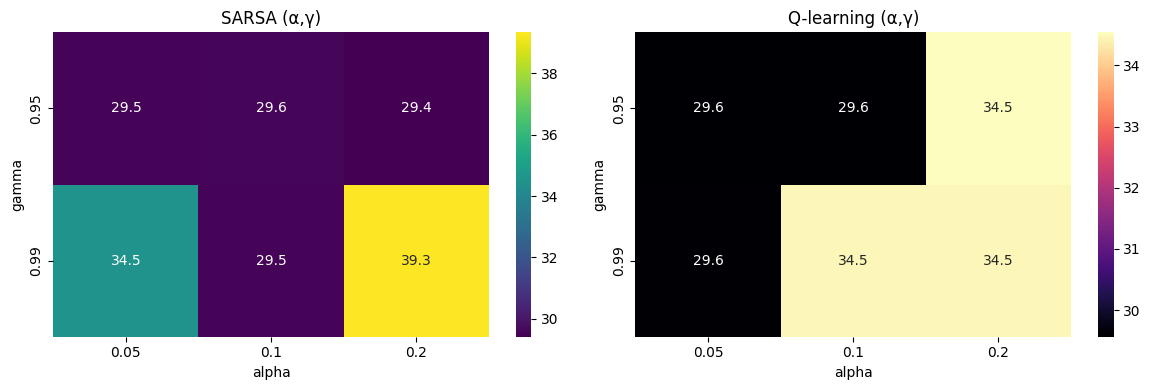

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.heatmap(pivot_sarsa, annot=True, fmt=".1f",
            cmap="viridis", ax=axes[0])
axes[0].set_title("SARSA (α,γ)")

sns.heatmap(pivot_q, annot=True, fmt=".1f",
            cmap="magma", ax=axes[1])
axes[1].set_title("Q-learning (α,γ)")

plt.tight_layout()
plt.show()


In [ ]:

df_summary['algo'] = 'MC'
df_sarsa['algo']   = 'SARSA'
df_q['algo']       = 'Q-learning'

df_all = pd.concat(
    [
        df_summary[['algo', 'epsilon', 'best_reward']],
        df_sarsa[['algo', 'epsilon', 'best_reward']],
        df_q[['algo', 'epsilon', 'best_reward']]
    ],
    ignore_index=True
)

pivot_eps = df_all.pivot(
    index='epsilon',
    columns='algo',
    values='best_reward'
).sort_index()

print("\n=== Best shaped reward for each algorithm under different ε ===")
print(pivot_eps)



=== Best shaped reward for each algorithm under different ε ===
algo        MC  Q-learning   SARSA
epsilon                           
0.1      59.31       54.25  39.480
0.5      24.62       29.63  34.555
0.9      19.73       19.69  19.725


In [ ]:
# ===== 1. Evaluate all three agents in greedy mode =====

env_eval = Tetris()

Q_mc_best    = Q_dict[best_eps_mc]
Q_sarsa_best = Q_sarsa_dict[best_eps_sarsa]
Q_q_best     = Q_q_dict[best_eps_q]

rw_mc,    lines_mc    = evaluate_agent_greedy(env_eval, Q_mc_best,    n_games=50)
rw_sarsa, lines_sarsa = evaluate_agent_greedy(env_eval, Q_sarsa_best, n_games=50)
rw_q,     lines_q     = evaluate_agent_greedy(env_eval, Q_q_best,     n_games=50)

print("\n===== EVALUATION RESULTS (50 games, greedy policy) =====")
print(f"MC       -> mean lines: {lines_mc.mean():.2f}, mean reward: {rw_mc.mean():.2f}")
print(f"SARSA    -> mean lines: {lines_sarsa.mean():.2f}, mean reward: {rw_sarsa.mean():.2f}")
print(f"Q-learning -> mean lines: {lines_q.mean():.2f}, mean reward: {rw_q.mean():.2f}")

import pandas as pd

df_eval = pd.DataFrame({
    "Algorithm": ["Monte Carlo", "SARSA", "Q-learning"],
    "Mean Lines Cleared": [lines_mc.mean(), lines_sarsa.mean(), lines_q.mean()],
    "Mean Reward (env)": [rw_mc.mean(), rw_sarsa.mean(), rw_q.mean()]
})

print("\n Evaluation Table ")
print(df_eval)



===== EVALUATION RESULTS (50 games, greedy policy) =====
MC       -> mean lines: 1.48, mean reward: 7.45
SARSA    -> mean lines: 1.38, mean reward: 6.64
Q-learning -> mean lines: 1.26, mean reward: 5.75

===== Evaluation Table =====
     Algorithm  Mean Lines Cleared  Mean Reward (env)
0  Monte Carlo                1.48             7.4490
1        SARSA                1.38             6.6440
2   Q-learning                1.26             5.7498


<Figure size 700x400 with 0 Axes>

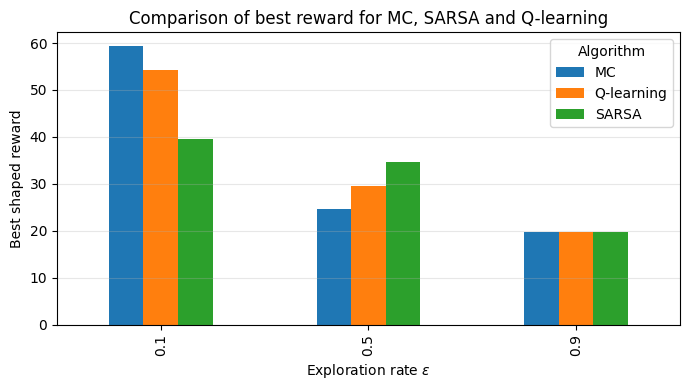

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))

pivot_eps.plot(kind='bar', figsize=(7,4))
plt.xlabel("Exploration rate $\\epsilon$")
plt.ylabel("Best shaped reward")
plt.title("Comparison of best reward for MC, SARSA and Q-learning")
plt.grid(axis='y', alpha=0.3)
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()


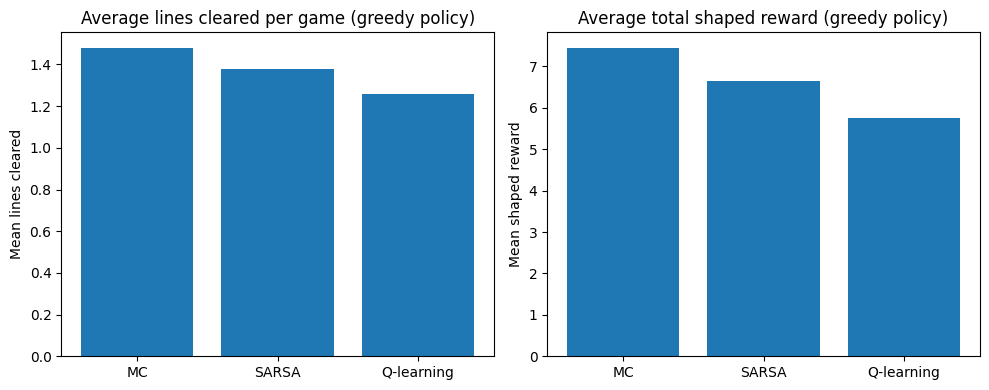

In [40]:
import matplotlib.pyplot as plt
import numpy as np

algos = ["MC", "SARSA", "Q-learning"]

mean_lines = [
    np.mean(lines_mc),
    np.mean(lines_sarsa),
    np.mean(lines_q)
]

mean_rewards = [
    np.mean(rw_mc),
    np.mean(rw_sarsa),
    np.mean(rw_q)
]

x = np.arange(len(algos))
width = 0.35

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.bar(x, mean_lines)
plt.xticks(x, algos)
plt.ylabel("Mean lines cleared")
plt.title("Average lines cleared per game (greedy policy)")

plt.subplot(1,2,2)
plt.bar(x, mean_rewards)
plt.xticks(x, algos)
plt.ylabel("Mean shaped reward")
plt.title("Average total shaped reward (greedy policy)")

plt.tight_layout()
plt.show()


In [41]:
import pandas as pd
import numpy as np

eps_list = [0.9, 0.5, 0.1]

rows = []

for algo in ["Q-learning", "Monte Carlo", "SARSA"]:
    for eps in eps_list:

        if algo == "Monte Carlo":
            ep_rewards = results_rewards[eps]
            Q_use      = Q_dict[eps]
        elif algo == "SARSA":
            ep_rewards = results_rewards_sarsa[eps]
            Q_use      = Q_sarsa_dict[eps]
        else:
            ep_rewards = results_rewards_q[eps]
            Q_use      = Q_q_dict[eps]

        best_train_reward = max(ep_rewards)

        env_eval = Tetris()
        rw_eval, lines_eval = evaluate_agent_greedy(
            env_eval, Q_use, n_games=30, max_steps=1000
        )

        rows.append({
            "Agent": algo,
            "ε Strategy": f"ε = {eps}",
            "Best train reward": round(best_train_reward, 2),
            "Eval mean lines":   round(lines_eval.mean(), 2),
            "Eval mean reward":  round(rw_eval.mean(), 2),
        })

df_table = pd.DataFrame(rows)
print(df_table)


===== BẢNG TỔNG HỢP (Python) =====
         Agent ε Strategy  Best train reward  Eval mean lines  \
0   Q-learning    ε = 0.9              19.69             0.80   
1   Q-learning    ε = 0.5              29.63             1.13   
2   Q-learning    ε = 0.1              54.25             1.17   
3  Monte Carlo    ε = 0.9              19.73             0.40   
4  Monte Carlo    ε = 0.5              24.62             0.87   
5  Monte Carlo    ε = 0.1              59.31             1.13   
6        SARSA    ε = 0.9              19.72             0.57   
7        SARSA    ε = 0.5              34.55             0.90   
8        SARSA    ε = 0.1              39.48             1.20   

   Eval mean reward  
0              4.15  
1              5.10  
2              5.29  
3              1.69  
4              4.15  
5              5.07  
6              2.33  
7              4.38  
8              5.47  
